In [1]:
import numpy as np
import csv
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt

In [2]:
import camera_tools as ct

In [3]:
from cmac2 import CMAC

In [123]:
#Calibrate the camera to detect green box, if you haven't done this calibration before
low_green, high_green = ct.colorpicker()
print(low_green)
print(high_green)

[ 25  85 133]
[146 113 239]


In [269]:
low_red, high_red = ct.colorpicker()
print(low_red)
print(high_red)

[ 65 169 146]
[132 191 255]


In [124]:
#Check whether the camera detects the green object properly
cam = ct.prepare_camera()
image = ct.capture_image(cam)
x,y = ct.locate(image, low_green, high_green)
ct.show_camera(cam)

print(x,y)

206 196


In [270]:
#Check whether the camera detects the green object properly
cam_red = ct.prepare_camera()
img_red = ct.capture_image(cam_red)
ct.show_camera(cam_red, low_red, high_red)

In [125]:
from FableAPI.fable_init import api
api.setup(blocking=True)

Dongle already connected
setup done


True

In [127]:
moduleids = api.discoverModules()
print("Module IDs: ", moduleids)
moduleID = moduleids[0]
print("Battery level:",api.getBattery(moduleID),"%")

Module IDs:  ['5YA ']
Battery level: 89.2 %


In [128]:
api.setPos(-90,0,moduleID)

0

In [129]:
#Create two files (if they were not already created) to collect data.
if (not os.path.exists("xycoords_2.csv")):
    f = open('xycoords_2.csv', 'w')
    with f:
        writer = csv.writer(f)
        writer.writerows([["X","Y"]])
    f.close()
if (not os.path.exists("angles_2.csv")):
    f = open('angles_2.csv','w')
    with f:
        writer = csv.writer(f)
        writer.writerows([["Y_angle"]])
    f.close()

In [130]:
#we use the collectData function to collect the data for training.
    #we collect Y (angular) position of the end effector
    #we collect x,y coordinates of the end effector in the camera image
    #see the video final_project_guidance.mp4
def collectData(desired_angle_change):
    cam = ct.prepare_camera()
    ct.show_camera(cam)
    cam.release()
    cam = ct.prepare_camera()
    api.setPos(-90,90,moduleID)
    api.sleep(1.5)
    Y_angle_list = []
    XY_coordinates_list = []
    traversed_directions = 0
    current_direction = 0     # 1 is for clockwise, 0 is for anticlockwise
    traversedDirections = 0
    num_of_iterations = (int)(np.round(360/desired_angle_change,1))
    #Fable's Y arm traverse anticlockwise
    if current_direction == 0:
        for i in range(num_of_iterations):
            img = ct.capture_image(cam)
            x,y = ct.locate(img, low_green, high_green)
            currentRobotYAng = (int)(np.round(api.getPos(1,moduleID),1))
            Y_angle_list.append([currentRobotYAng])
            XY_coordinates_list.append([x,y])
            currentRobotYAng = currentRobotYAng - (desired_angle_change)
            api.setPos(-90,currentRobotYAng,moduleID)
            api.sleep(1.5)
            if np.abs(currentRobotYAng) > 90:
                current_direction = 1
                traversedDirections = traversedDirections + 1
                break
    #Fable's Y Arm traverses clockwise
    if current_direction == 1:
        for i in range(num_of_iterations):
            img = ct.capture_image(cam)
            x,y = ct.locate(img, low_green, high_green)
            currentRobotYAng = (int)(np.round(api.getPos(1,moduleID),1))
            Y_angle_list.append([currentRobotYAng])
            XY_coordinates_list.append([x,y])
            currentRobotYAng = currentRobotYAng + (desired_angle_change)
            api.setPos(-90,currentRobotYAng,moduleID)
            api.sleep(1.5)
            if np.abs(currentRobotYAng) > 90:
                current_direction = 0
                traversedDirections = traversedDirections + 1
                break
    if traversedDirections == 2:
        cam.release()
        #Save collected data to files
        y_angle_file_ptr = open('angles_2.csv', 'a+', newline ='')
        with y_angle_file_ptr:
            writer = csv.writer(y_angle_file_ptr)
            writer.writerows(Y_angle_list)
        y_angle_file_ptr.close()
        file_xycoords = open('xycoords_2.csv', 'a+', newline ='')
        with file_xycoords:
            writer = csv.writer(file_xycoords)
            writer.writerows(XY_coordinates_list)
        file_xycoords.close()
    return
    

In [218]:
#TODO: Call the CollectData() function with different values for 'desired_angle_change' argument and collect sufficient
#sufficient amout of data to angles_2.csv file and xycoords_2.csv file.
collectData(5)

In [219]:
#Use this function to calculate Y (angular) position errors 
# Y (angular) positions
def readAngleFilesAndCollectErrors(fileName):
    angleDataFrame = pd.read_csv(fileName)
    desired_column = angleDataFrame.columns[0]
    angle_error_list = []
    for i in range(1,len(angleDataFrame)):
        current_data_element = angleDataFrame[desired_column][i]
        previous_data_element = angleDataFrame[desired_column][i-1]
        #TODO: Calculate the Y (angular) position error(say current_error) as the difference between 
        # the current Y (angular) position and previous Y (angular) position
        current_error = current_data_element - previous_data_element
        #print(current_data_element," ", previous_data_element, " ", current_error)
        angle_error_list = angle_error_list + [current_error]
    return angle_error_list

In [220]:
#Use this function to calculate errors between x and y coordinates
def readXYCoordsFilesAndCollectErrors(fileName):
    xyCoordsDataFrame = pd.read_csv(fileName)
    x_col_name = xyCoordsDataFrame.columns[0]
    y_col_name = xyCoordsDataFrame.columns[1]
    x_pos_error_list = []
    y_pos_error_list = []
    for i in range(1,len(xyCoordsDataFrame)):
        current_data_element_x = xyCoordsDataFrame[x_col_name][i]
        current_data_element_y = xyCoordsDataFrame[y_col_name][i]
        previous_data_element_x = xyCoordsDataFrame[x_col_name][i-1]
        previous_data_element_y = xyCoordsDataFrame[y_col_name][i-1]
        error_x_pos = current_data_element_x - previous_data_element_x 
        error_y_pos = current_data_element_y - previous_data_element_y
        x_pos_error_list = x_pos_error_list + [error_x_pos]
        y_pos_error_list = y_pos_error_list + [error_y_pos] 
    return [x_pos_error_list,y_pos_error_list]

In [221]:
#Read the provided files and load the calculated errors into to appropriate lists as follows
# angle_error_list_1 = readAngleFilesAndCollectErrors("angles_1.csv")
# x_pos_error_list_1,y_pos_error_list_1 = readXYCoordsFilesAndCollectErrors("xyCoords_1.csv")
#Read the files with the data dumped by you and load the calculated errors into appropriate lists.
angle_error_list_2 = readAngleFilesAndCollectErrors("angles_2.csv")
x_pos_error_list_2,y_pos_error_list_2 = readXYCoordsFilesAndCollectErrors("xyCoords_2.csv")

Remove any nans

In [222]:
x_coord_error_array = np.array(x_pos_error_list_2)
y_coord_error_array = np.array(y_pos_error_list_2)
angle_error_array = np.array(angle_error_list_2)
print("Angle errors: ",angle_error_array.shape)
print("X position errors: ",x_coord_error_array.shape)
print("Y position errors: ",y_coord_error_array.shape)

Angle errors:  (108,)
X position errors:  (108,)
Y position errors:  (108,)


In [223]:
# Get a boolean mask where True indicates the location of NaNs in angle_error_array
nan_mask = np.isnan(x_coord_error_array)

# Use this mask to remove corresponding elements from x_coord_error_array and y_coord_error_array
x_coord_error_array = x_coord_error_array[~nan_mask]
y_coord_error_array = y_coord_error_array[~nan_mask]

# Now remove the NaNs from angle_error_array
angle_error_array = angle_error_array[~nan_mask]

print(angle_error_array.shape, x_coord_error_array.shape, y_coord_error_array.shape)

(108,) (108,) (108,)


Merge them

In [224]:
# Here we use 80% of the collected data  as the training set and 20% of the collected data as test set.
#TODO: Assign different propotions of the collected data set and test set and check how the test set error varies of the 
#Neural Network
data =  np.vstack((x_coord_error_array,y_coord_error_array)).T
target = np.vstack(angle_error_array)
data_input_tensor = torch.tensor(data.tolist()).float()
data_target_tensor = torch.tensor(target.tolist()).float()
data_with_target = torch.cat((data_input_tensor,data_target_tensor),1)
#TODO: what is the importance of using DataLoader utility function here?
loader= torch.utils.data.DataLoader(data_with_target,
                                     batch_size=data_with_target.size()[0], shuffle=True,
                                     num_workers=0)
#training set
train_set = []
#test set
test_set = []
for i in iter(loader):
    train_set_index = (int)(np.round(i.shape[0]*0.8))
    train_set = i[:train_set_index,:]
    test_set = i[train_set_index:,:]

In [225]:
print(train_set.shape)
print(test_set.shape)

torch.Size([86, 3])
torch.Size([22, 3])


In [226]:
#Defining Neural Network Model
class NN(torch.nn.Module):
    def __init__(self,n_feature,n_hidden1,n_hidden2,n_output):
        super(NN,self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature,n_hidden1)
        #self.do1 = torch.nn.Dropout(0.15)
        #self.relu1 = torch.nn.LeakyReLU()
        #self.bn1 = torch.nn.BatchNorm1d(n_hidden1,affine=False)
        self.hidden2 = torch.nn.Linear(n_hidden1,n_hidden2)
        #self.bn2 = torch.nn.BatchNorm1d(n_hidden2,affine=False)
        #self.relu2 = torch.nn.LeakyReLU()
        #self.do2 = torch.nn.Dropout(0.1)
        self.predict = torch.nn.Linear(n_hidden2,n_output)
        
        
    def forward(self,x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        #x = self.do1(x)
        x = self.hidden2(x)
        x = torch.sigmoid(x)
        #x = self.do2(x)
        x = self.predict(x)
        return x

In [227]:
#instantiate the Neural Network
#model = NN(n_feature=2,n_hidden1=17,n_hidden2=7, n_output=1)
model = NN(n_feature=2,n_hidden1=100,n_hidden2=100, n_output=1)

In [228]:
#Define loss function : 
# here we use Mean Square Error as the loss function
loss_func = torch.nn.MSELoss()

In [229]:
#Define the optimizer that should be used in training the Neural Network.
# Here 'lr' is the learning rate
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [230]:
train_set_inputs = train_set[:,:2]
#TODO: calculate the mean value of the train_set_inputs. 
mean_of_train_input = torch.mean(train_set_inputs,0)
#standard deviation of the train set inputs.
std_of_the_train_input = torch.std(train_set_inputs,0)
#here we normalize the inputs of the neural network. What is the importance of that?
normalized_train_set_inputs = (train_set_inputs - mean_of_train_input)/std_of_the_train_input

In [231]:
#targets of the training set
train_set_targets = train_set[:,2][:,np.newaxis]

In [232]:
print(normalized_train_set_inputs.shape)
print(train_set_targets.shape)

torch.Size([86, 2])
torch.Size([86, 1])


In [233]:
#TODO: train the Neural network model by changing the hyper parameters such as learning rate, number of epochs, number of neurons in hidden layers of the neural network.
# What is the minimum mean square error that you can achieve as your neural network converges for the training set.
#  (you will be able to achive a MSE of less than 10 as the Neural network converges.)
num_epochs = 2000
losslist = []
for _ in range(num_epochs):
    with torch.autocast(device_type="cpu", dtype=torch.bfloat16):
        prediction = model(normalized_train_set_inputs) # Forward pass prediction. Saves intermediary values required for backwards pass
        loss = loss_func(prediction, train_set_targets) # Computes the loss for each example, using the loss function defined above
    optimizer.zero_grad() # Clears gradients from previous iteration
    loss.backward() # Backpropagation of errors through the network
    optimizer.step() # Updating weights
    # print("prediction =",prediction)
    # print("Loss: ", loss.detach().numpy())
    losslist.append(loss.detach().numpy())
print("Min Loss: ", losslist[-1])

Min Loss:  4.0394225


In [152]:
# print("Loss: ", losslist)

Loss:  1.8375


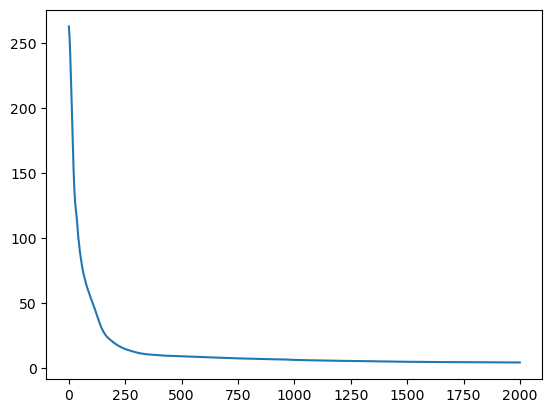

In [234]:
#plot the mean square error in each epoch/iteration
plt.plot(np.arange(len(losslist)),losslist)
plt.show()

In [235]:
#save the best neural network model you have obtained.
torch.save(model.state_dict(), 'best_nn_model.pth')

#Save the mean and standard deviation of the train set inputs because we need to use them at test time.

In [236]:
#reload the your best neural network model with saved parameters
model = NN(n_feature=2,n_hidden1=100,n_hidden2=100, n_output=1)
model.load_state_dict(torch.load('best_nn_model.pth'))

<All keys matched successfully>

In [237]:
#TODO: Extract inputs of the test_set
test_set_inputs = test_set[:,:2]
#TODO: Extract test set targets from the test_set
test_set_targets = test_set[:,2][:,np.newaxis]
print(test_set_inputs)

tensor([[-70.,   0.],
        [  3.,   1.],
        [ -6.,   2.],
        [ -2.,   2.],
        [ 13.,   0.],
        [ 23.,   0.],
        [ -2.,   2.],
        [ -2.,   0.],
        [ 48.,  -8.],
        [-48.,   6.],
        [  0.,   4.],
        [ 10.,  -2.],
        [ 15.,   0.],
        [-56.,   6.],
        [ 20.,  -2.],
        [-16.,   0.],
        [  4.,   2.],
        [ 57.,  21.],
        [ 56.,  -4.],
        [ 72.,   0.],
        [  8.,  -2.],
        [ -5.,   0.]])


In [238]:
#TODO: Normalize test set inputs by using the mean and standard deviation of the inputs of the training set
normalized_test_set_inputs = (test_set_inputs - mean_of_train_input)/std_of_the_train_input
# print(normalized_test_set_inputs)

In [239]:
#TODO: feed the normalized test set inputs to the Neural Network model and obtain the prediction for the test set.
prediction_test = model(normalized_test_set_inputs)

In [240]:
print(prediction_test.shape)

torch.Size([22, 1])


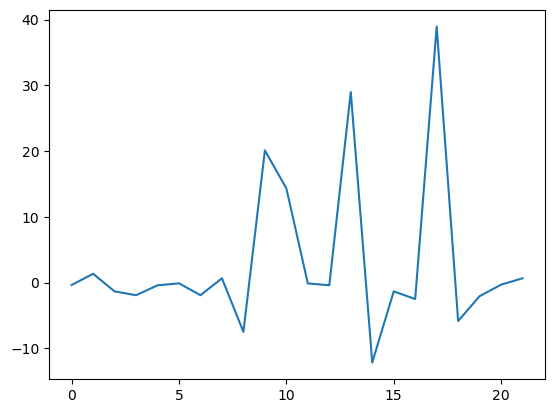

In [241]:
#plot the prediction error of the test set
test_set_prediction_error = prediction_test - test_set_targets
# print(prediction_test)
plt.plot(np.arange(len(test_set_prediction_error.tolist())),test_set_prediction_error.tolist())

In [ ]:
# In the example model trained with about 600 data, from a test set of 165 samples,
# 159 samples are predicted with prediction error less than 10.

In [ ]:
#TODO: Based on the prediction error of the test set, you can try to train the neural network again by changing the hyper parameters mentioned above.
# Also Try to add Dropout layers to the Neural network and check whether test prediction errors can be reduced further.

# DETECTING THE OBJECT AT TESTING PHASE

In [242]:
A = 130
T = 100

In [243]:
api.setPos(-90,90,moduleID)

0

In [33]:
#TODO: Detect the target object and obtain the coordinates of the object in the image
cam = ct.prepare_camera()
img = ct.capture_image(cam)
# ct.show_camera(cam, low_green, high_green)
x,y = ct.locate(img, low_green, high_green)
print(x,y)
target_x = x
target_y = y
# print("target_x = ",target_x)
# print("target_y = ",target_y)

None None


In [268]:
api.setPos(-90,0,moduleID)

0

0 376 522
1 470 482
2 473 504
3 475 522
4 475 516
5 475 430
6 464 436
7 440 422
8 432 366
9 396 278
10 286 270
11 276 280
12 294 284
13 288 282
14 278 294
15 294 296
16 302 294
17 294 296
18 304 294
19 296 456
20 442 456
21 450 452
22 454 452
23 454 454
24 448 454
25 460 456
26 456 454
27 454 456
28 458 176
29 312 170
30 160 174
31 173 176
32 185 176
33 179 178
34 176 178
35 185 182
36 178 301
37 318 398
38 384 426
39 433 458
40 452 472
41 459 394
42 432 398
43 394 320
44 344 286
45 294 258
46 230 202
47 178 162
48 176 232
49 248 286


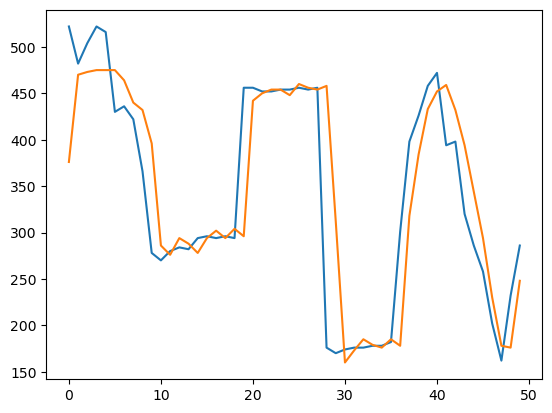

In [273]:
#Here we implement the control loop which is having Neural Network as the controller.
#In this case we donot integrate CMAC to the control loop
def ControlLoopWithNNWithoutCMAC(target__x_coordinate,target__y_coordinate):


    x_ref_vec = []
    x_act_vec = []

    number_of_iterations_for_convergence = 0
    #TODO:Intialize your best neural network model and load the saved paramemeters
    NN_model = NN(n_feature=2,n_hidden1=100,n_hidden2=100, n_output=1)
    NN_model.load_state_dict(torch.load('best_nn_model.pth'))
    
    #Here we loop for 50 iterations assuming that 
    # the controller should achieve the desired target within atmost 50 iterations
    for i in range(50):
        cam = ct.prepare_camera()
        img = ct.capture_image(cam)
        x,y = ct.locate(img,low_green, high_green)

        cam_red = ct.prepare_camera()
        img_red = ct.capture_image(cam)
        x_red,y_red = ct.locate(img,low_red, high_red)

        # print(x,y)

        # x_ref = A * np.sin(2*np.pi * i/T) + 300
        # x_ref = 400
        x_ref = x_red
        y_ref = y
        

        x_ref_vec.append(x_ref)
        x_act_vec.append(x)

        print(i, x, x_ref)

        x_ref = float(x_ref)
        y_ref = float(y_ref)

        robot_x_coord_in_image = x
        robot_y_coord_in_image = y
        x_coord_error = x_ref - robot_x_coord_in_image;
        y_coord_error = y_ref - robot_y_coord_in_image;

        #Here if the errors are less than twenty pixels we assume robot reaches the target. 
        # However you can choose any reasonable threshold value instead of 20.
        # if (np.abs(x_coord_error) < (1+x_prev*1.02) and np.abs(y_coord_error) < (1+y_coord_error*1.02)):
        #     print("number of iterations for convergence = ", number_of_iterations_for_convergence)
        #     break

        xy_input_nn_model = [x_coord_error, y_coord_error]
        # print(xy_input_nn_model)
        
        #TODO: normalize the input to the Neural network model using meaning and variance of the training set inputs.
        normalize_xy_input_nn_model = (torch.tensor(xy_input_nn_model) - mean_of_train_input)/std_of_the_train_input

        prediction_for_Y_pos_increment = NN_model(normalize_xy_input_nn_model)

        #TODO: Get the current Y (angular) position/angle of the robot. you can use the api.getPos function of fable
        robot_current_Y_pos = api.getPos(1,moduleID)
        #Next Y angular position of the robot will be robot_Y_pos + prediction_for_Y_pos_increment
        robot_next_Y_pos = robot_current_Y_pos + prediction_for_Y_pos_increment
        # print(robot_next_Y_pos)
        #TODO: Set the next position of the robot to (-90,robot_next_Y_pos) using the setPos function of the fable.

        if robot_next_Y_pos > 90:
            robot_next_Y_pos = 90
        elif robot_next_Y_pos < -90:
            robot_next_Y_pos = -90

        api.setPos(-90,robot_next_Y_pos,moduleID)
        api.sleep(1)
        number_of_iterations_for_convergence = number_of_iterations_for_convergence + 1

    return [x_ref_vec,x_act_vec]

#TODO: Call the control loop for a target which is detected. Record the number of iterations that the control loop spent for convergence.
[ref_ANN, act_ANN] = ControlLoopWithNNWithoutCMAC(target_x,target_y)
#TODO: change your target location and try again. You may change the target 4-5 times and check how the control loop work.
#Record the number of iterations that the control loop spent for convergence.
plt.plot(np.arange(len(ref_ANN)),ref_ANN)
plt.plot(np.arange(len(act_ANN)),act_ANN)
plt.show()

In [265]:
api.setPos(-90,90,moduleID)

0

0 324 592.0
angle cmac: 0.04825266023189323
1 464 474.0
angle cmac: -3.6670713292628454
2 474 464.0
angle cmac: -4.421807418213065
3 474 482.0
angle cmac: -3.893121553235603
4 475 472.0
angle cmac: -5.083942357230243
5 475 432.0
angle cmac: -4.375232657215679
6 466 402.0
angle cmac: -1.5327178868801823
7 448 408.0
angle cmac: 0.8748097732352711
8 416 406.0
angle cmac: 3.147844978022422
9 404 406.0
angle cmac: 3.490811856200668
10 404 406.0
angle cmac: 2.9718288902976306
11 402 414.0
angle cmac: 2.2493633352140847
12 408 420.0
angle cmac: 1.3677230086305707
13 416 424.0
angle cmac: 0.5783948563824728
14 434 424.0
angle cmac: -0.422292269382202
15 432 424.0
angle cmac: 0.1279290907365862
16 425 424.0
angle cmac: 0.5661980834329858
17 420 404.0
angle cmac: 1.4104147570306864
18 410 198.0
angle cmac: 2.2885970205055397
19 224 198.0
angle cmac: 5.753259874864433
20 162 202.0
angle cmac: 5.910572640655641
21 204 206.0
angle cmac: 4.425887638890209
22 202 208.0
angle cmac: 3.8241323674295638


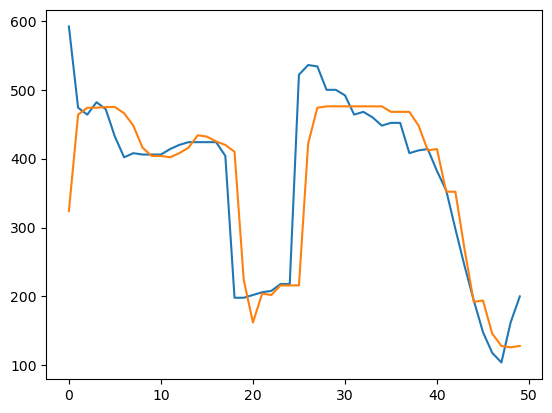

In [274]:
#Now integrate the CMAC to the previous control loop which had only the Neural Network. 
#The implementation of the CMAC can be found in code given for second week exercises.
#TODO: Implement the control loop with both neural network and CMAC. 
def ControlLoopWithBothNNandCMAC(target_x, target_y, iter_num):
    
    # api.setPos(-90,0,moduleID)
    target_x_coord = target_x
    target_y_coord = target_y

    x_ref_vec = []
    x_act_vec = []

    number_of_iterations_for_convergence = 0
    max_iter = iter_num
    #TODO:Intialize your best neural network model and load the saved paramemeters
    NN_model = NN(n_feature=2,n_hidden1=100,n_hidden2=100, n_output=1)
    NN_model.load_state_dict(torch.load('best_nn_model.pth'))

    ## TODO: CMAC initialization
    n_rfs = 3
    beta = 0.1

    xmin = [152,152]
    xmax = [480, 480]

    c = CMAC(n_rfs, xmin, xmax, beta)

    ## Simulation loop
    for i in range(max_iter):
       
        cam = ct.prepare_camera()
        img = ct.capture_image(cam)
        x,y = ct.locate(img,low_green, high_green)

        cam_red = ct.prepare_camera()
        img_red = ct.capture_image(cam)
        x_red,y_red = ct.locate(img,low_red, high_red)

        # x_ref = A * np.sin(2*np.pi * i/T) + 300
        # x_ref = 400
        x_ref = x_red
        y_ref = y

        x_ref = float(x_ref)
        y_ref = float(y_ref)

        print(i, x, x_ref)

        x_ref_vec.append(x_ref)
        x_act_vec.append(x)

        # print(x,y)
        robot_x_coord_in_image = x
        robot_y_coord_in_image = y
        x_coord_error = x_ref - robot_x_coord_in_image;
        y_coord_error = y_ref - robot_y_coord_in_image;
        
        ## TODO: Implement the CMAC controller into the loop
        x_cmac = [x_ref ,robot_x_coord_in_image]
        angle_cmac = c.predict(x_cmac)

        # print(x_cmac)        
    
        #Here if the errors are less than twenty pixels we assume robot reaches the target. 
        # However you can choose any reasonable threshold value instead of 20.
        # if (np.abs(x_coord_error) < (1+x_prev*1.02) and np.abs(y_coord_error) < (1+y_coord_error*1.02)):
        #     print("number of iterations for convergence = ", number_of_iterations_for_convergence)
        #     break
        
        xy_input_nn_model = [x_coord_error,y_coord_error]
       
        #TODO: normalize the input to the Neural network model using meaning and variance of the training set inputs.
        normalize_xy_input_nn_model = (torch.tensor(xy_input_nn_model) - mean_of_train_input)/std_of_the_train_input
    
        prediction_for_Y_pos_increment = NN_model(normalize_xy_input_nn_model)
        # print(prediction_for_Y_pos_increment)
        #TODO: Get the current Y (angular) position/angle of the robot. you can use the api.getPos function of fable
        robot_current_Y_pos = api.getPos(1,moduleID)
        #Next Y angular position of the robot will be robot_Y_pos + prediction_for_Y_pos_increment
        robot_next_Y_pos = robot_current_Y_pos + prediction_for_Y_pos_increment
        
        c.learn(prediction_for_Y_pos_increment.detach().numpy())
        print("angle cmac:", angle_cmac)
        robot_nn_and_cmac = robot_next_Y_pos + angle_cmac

        #TODO: Set the next position of the robot to (-90,robot_next_Y_pos) using the setPos function of the fable.
        if robot_nn_and_cmac > 90:
            robot_nn_and_cmac = 90
        elif robot_nn_and_cmac < -90:
            robot_nn_and_cmac = -90
            
        api.setPos(-90,robot_nn_and_cmac,moduleID)
        api.sleep(1)
        number_of_iterations_for_convergence = number_of_iterations_for_convergence + 1

    return [x_ref_vec,x_act_vec]

[ref_CMAC,act_CMAC] = ControlLoopWithBothNNandCMAC(0,0, 50)
plt.plot(np.arange(len(ref_CMAC)),ref_CMAC)
plt.plot(np.arange(len(act_CMAC)),act_CMAC)
plt.show()

In [277]:
api.setPos(-90,90,moduleID)

0

0 398 580.0
0.0
1 478 564.0
0.0
2 476 554.0
0.0
3 476 548.0
0.0
4 478 542.0
0.06705632772315866
5 478 528.0
0.3576848833804137
6 478 522.0
1.0233042981975218
7 478 454.0
2.303826649382437
8 474 408.0
2.1433425131749857
9 459 404.0
-1.3038725353121516
10 432 398.0
-6.616287020638845
11 392 396.0
-11.813129069601423
12 384 354.0
-12.408357582551744
13 338 234.0
-18.998675262865234
14 198 238.0
-42.70938543123932
15 192 250.0
-35.11377742792525
16 214 250.0
-20.787735050911657
17 234 248.0
-11.51394935915108
18 251 253.0
-7.872035748873684
19 242 230.0
-7.45670956409198
20 234 88.0
-11.180794055462894
21 128 86.0
-56.58438794368542
22 125 86.0
-70.93284670150706
23 128 94.0
-82.37648806933336
24 128 96.0
-90.19709459615545
25 128 242.0
-94.44489094318908
26 125 278.0
-58.9630683452527
27 130 282.0
-21.398653407095974
28 226 280.0
5.493953819655535
29 304 282.0
11.951210803317935
30 296 282.0
8.911609852856103
31 288 282.0
7.238771531428663
32 290 288.0
6.425425241723975
33 308 286.0
5.984

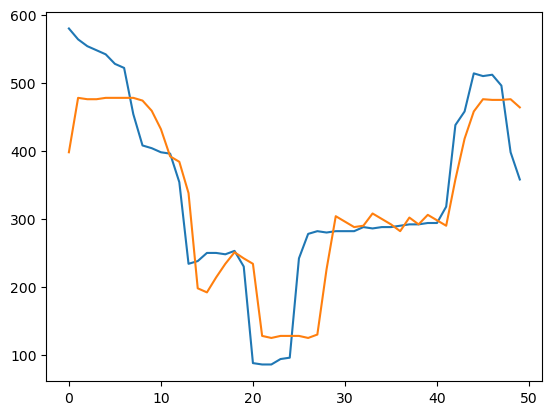

In [280]:
from adaptive_filter.cerebellum import AdaptiveFilterCerebellum

def NNwithAF(target_x, target_y, iter_num):

    target_x_coord = target_x
    target_y_coord = target_y
    number_of_iterations_for_convergence = 0
    max_iter = iter_num
    #TODO:Intialize your best neural network model and load the saved paramemeters
    NN_model = NN(n_feature=2,n_hidden1=100,n_hidden2=100, n_output=1)
    NN_model.load_state_dict(torch.load('best_nn_model.pth'))

    x_ref_vec = []
    x_act_vec = []

    ## TODO: AF initialization
    Ts = 1e-4
    n_inputs = 1
    n_outputs = 1
    n_bases = 50
    beta = 50

    af = AdaptiveFilterCerebellum(Ts, n_inputs, n_outputs, n_bases, beta)

    robot_input = 0

    ## Simulation loop
    for i in range(max_iter):
       
        cam = ct.prepare_camera()
        img = ct.capture_image(cam)
        x,y = ct.locate(img,low_green, high_green)

        cam_red = ct.prepare_camera()
        img_red = ct.capture_image(cam)
        x_red,y_red = ct.locate(img,low_red, high_red)

        # x_ref = A * np.sin(2*np.pi * i/T) + 300
        # x_ref = 400
        x_ref = x_red
        y_ref = y

        x_ref = float(x_ref)
        y_ref = float(y_ref)

        print(i, x, x_ref)

        x_ref_vec.append(x_ref)
        x_act_vec.append(x)

        # print(x,y)
        robot_x_coord_in_image = x
        robot_y_coord_in_image = y
        x_coord_error = x_ref - robot_x_coord_in_image;
        y_coord_error = y_ref - robot_y_coord_in_image;
        
        ## TODO: Implement the CMAC controller into the loop
       
        af_out = af.step(robot_input, x_coord_error)
        print(af_out)
        x_coord_error = x_coord_error + af_out
        
        #Here if the errors are less than twenty pixels we assume robot reaches the target. 
        # However you can choose any reasonable threshold value instead of 20.
        # if (np.abs(x_coord_error) < (1+x_prev*1.02) and np.abs(y_coord_error) < (1+y_coord_error*1.02)):
        #     print("number of iterations for convergence = ", number_of_iterations_for_convergence)
        #     break
        
        xy_input_nn_model = [x_coord_error,y_coord_error]
    
        #TODO: normalize the input to the Neural network model using meaning and variance of the training set inputs.
        normalize_xy_input_nn_model = (torch.tensor(xy_input_nn_model) - mean_of_train_input)/std_of_the_train_input
   
        prediction_for_Y_pos_increment = NN_model(normalize_xy_input_nn_model)
        # print(prediction_for_Y_pos_increment)
        #TODO: Get the current Y (angular) position/angle of the robot. you can use the api.getPos function of fable
        robot_current_Y_pos = api.getPos(1,moduleID)
        #Next Y angular position of the robot will be robot_Y_pos + prediction_for_Y_pos_increment
        robot_next_Y_pos = robot_current_Y_pos + prediction_for_Y_pos_increment
       
        robot_nn_and_af = robot_next_Y_pos
        robot_input = prediction_for_Y_pos_increment.detach().numpy()

        #TODO: Set the next position of the robot to (-90,robot_next_Y_pos) using the setPos function of the fable.

        if robot_nn_and_af > 90:
            robot_nn_and_af = 90
        elif robot_nn_and_af < -90:
            robot_nn_and_af = -90

        api.setPos(-90,robot_nn_and_af,moduleID)
        api.sleep(0.7)
        number_of_iterations_for_convergence = number_of_iterations_for_convergence + 1
        

    return [x_ref_vec,x_act_vec]

[ref_AF,act_AF] = NNwithAF(0,0, 50)
plt.plot(np.arange(len(ref_AF)),ref_AF)
plt.plot(np.arange(len(act_AF)),act_AF)
plt.show()

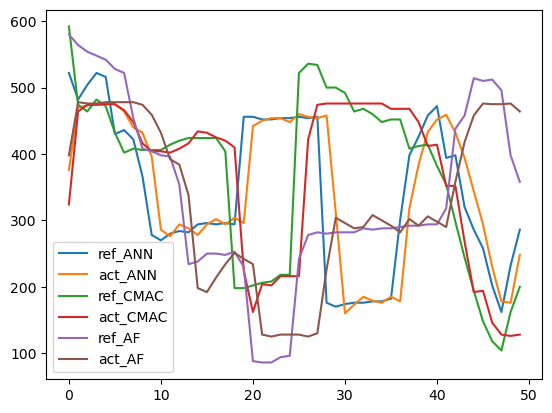

In [281]:
plt.plot(np.arange(len(ref_ANN)),ref_ANN)
plt.plot(np.arange(len(act_ANN)),act_ANN)
plt.plot(np.arange(len(ref_CMAC)),ref_CMAC)
plt.plot(np.arange(len(act_CMAC)),act_CMAC)
plt.plot(np.arange(len(ref_AF)),ref_AF)
plt.plot(np.arange(len(act_AF)),act_AF)
plt.legend(["ref_ANN","act_ANN","ref_CMAC","act_CMAC","ref_AF","act_AF"])
plt.show()

In [ ]:
#TODO: Compare the number of iteration it takes for convergence in the control loop with 
# neural network only and with both CMAC and neural network.